<a href="https://colab.research.google.com/github/CantoneseCounsellorChatbot/CantoneseChatbot/blob/main/chatbot_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
!rm -rf /content/CantoneseChatbot
!pip install torch
!pip install simpletransformers
!pip install pytorch_pretrained_bert
# !pip install sqlite3
!git clone https://github.com/CantoneseCounsellorChatbot/CantoneseChatbot.git
# download question retrieval model
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1r5GRL51-DzoFrl3ba01HZqlPqmVu9cGv' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1r5GRL51-DzoFrl3ba01HZqlPqmVu9cGv" -O pretrain-model.zip
!rm -rf /tmp/cookies.txt
! unzip -o -d CantoneseChatbot/ pretrain-model.zip

fatal: destination path 'CantoneseChatbot' already exists and is not an empty directory.
Archive:  pretrain-model.zip
  inflating: CantoneseChatbot/pretrain-model/output_BTS_re+pr05190/model/config.json  
  inflating: CantoneseChatbot/pretrain-model/output_BTS_re+pr05190/model/BertAbsSum_14.bin  
  inflating: CantoneseChatbot/pretrain-model/regression_question/bestmodel/eval_results.txt  
  inflating: CantoneseChatbot/pretrain-model/regression_question/bestmodel/scheduler.pt  
  inflating: CantoneseChatbot/pretrain-model/regression_question/bestmodel/special_tokens_map.json  
  inflating: CantoneseChatbot/pretrain-model/regression_question/bestmodel/vocab.txt  
  inflating: CantoneseChatbot/pretrain-model/regression_question/bestmodel/tokenizer_config.json  
  inflating: CantoneseChatbot/pretrain-model/regression_question/bestmodel/model_args.json  
  inflating: CantoneseChatbot/pretrain-model/regression_question/bestmodel/training_args.bin  
  inflating: CantoneseChatbot/pretrain-mode

In [60]:
import sys
# from google.colab import drive
# drive.mount('/content/drive')
sys.path.append('/content/CantoneseChatbot/')
from datetime import time
import time
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, random_split
from tqdm import tqdm
from simpletransformers.classification import ClassificationModel
from transformers import BertTokenizer, BertForSequenceClassification
# import sqlite3
import re
# from models import *


In [73]:
import sys
# from google.colab import drive
# drive.mount('/content/drive')
# sys.path.append('/content/drive/My Drive/chatbot/BertSum')
from datetime import time
import time
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, random_split
from tqdm import tqdm
from simpletransformers.classification import ClassificationModel
from transformers import BertTokenizer, BertForSequenceClassification
# import sqlite3
import re
import matplotlib.pyplot as plt

def regressionReply(post,model,candidate):
  model = ClassificationModel("bert", model )
  data=pd.read_csv(candidate)
  advice_list = data.advice.drop_duplicates().to_list()      
  np.random.shuffle(advice_list)
  tmp=[]
  for advice in advice_list:
      tmp.append([post,advice])


  predictions, raw_outputs = model.predict(tmp)
  topindex=np.argmax(predictions)
  
  
  return tmp[topindex][1],max(predictions)

'''
def regressionReply(post,model,candidate):
  # print("regression")
  tokenizer = BertTokenizer.from_pretrained(model)
  model = BertForSequenceClassification.from_pretrained(model)
  model.to('cuda')
  data=pd.read_csv(candidate)
  advice_list = data.advice.drop_duplicates().to_list()
  text=post

  input_ids = []
  attention_masks = []
  for a in advice_list:
      encoded_dict = tokenizer.encode_plus(
                      text+"[SEP]"+a,                      # Sentence to encode.
                      add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                      max_length = 50,           # Pad & truncate all sentences.
                      pad_to_max_length = True,
                      return_attention_mask = True,   # Construct attn. masks.
                      return_tensors = 'pt',     # Return pytorch tensors.
                  )
      input_ids.append(encoded_dict['input_ids'])
      attention_masks.append(encoded_dict['attention_mask'])
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  batch_size = 32
  # print("chatbot:{}".format(advice))
  prediction_data = TensorDataset(input_ids, attention_masks)
  prediction_sampler = SequentialSampler(prediction_data)
  prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)
  
  predictions  = []
  # print("regression2")
  # Predict 
  for batch in tqdm(prediction_dataloader):
      batch = tuple(t.to("cuda") for t in batch)
      b_input_ids, b_input_mask = batch
      with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = outputs[0]
      logits = logits.detach().cpu().numpy().reshape(-1).tolist()
  #     label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
      predictions+=logits
  #   true_labels.append(label_ids)

  return advice_list[np.argmax(predictions)], np.max(predictions)

'''


def general(aa):
    max_tail_length=10
    def getQAlist():
        qaList = []
        exact_list=[]
        conn = pd.read_csv("/content/CantoneseChatbot/keyword_list.csv")
        exact_match = conn[conn.KeywordMatch=="no"]
        conn=conn[conn.KeywordMatch=="yes"]
        for index,row in exact_match.iterrows():
            tmp = {"Q":""+row["Q"],"A":""+row["A"]}
            exact_list.append(tmp)

        
        
        for index,row in conn.iterrows():
          if row["Q"]!="*":
            tmp = {"Q":""+row["Q"],"A":""+row["A"]}
            qaList.append(tmp)
          else:
            genreal_reply=row["A"].split("|")
        return exact_list,qaList,genreal_reply

    def answer(say,seg):
        if (say[0]=="你") and (say.find("唔")>0):
            msg = handleSpecial(say,seg)
            if msg !="":
                return msg
        return "@eliza@ " + getAnswer(say)
    def getAnswer(say):
        exactmatch,tmpList,general_reply=getQAlist()
        results = analyzeSay(say, tmpList, general_reply,exactmatch)
        
        msg=results[1]
        if msg !="":
            return msg
        else:
            return "然後呢？@发生错误@"

    def analyzeSay(say, tmpList, general_reply,exactmatch):
        exact_df = pd.DataFrame(exactmatch)
        if say in exact_df.Q.to_list():
          return exact_df[exact_df.Q==say].A.item()
        patterns = []
        for i in range(len(tmpList)):
            qa = tmpList[i]
            qList = qa["Q"].split(" | ")
            aList = qa["A"].split("|")            
            elizakeyword = []
            for j in range(len(qList)):
                qi = qList[j]
 


                if say.find(qi) >-1:


                    elizakeyword.append(qi)
                    tt=handlePunc(say, qi)

                    tail = getTail(tt, qi)

                    replacedTail = tail.replace("我", "#")
                    replacedTail = replacedTail.replace("你", "我")
                    replacedTail = replacedTail.replace("#", "你")
                    tmpalist =aList[np.random.randint(len(aList))]
                    if tmpalist.find("*")>-1:
                      if len(replacedTail)<max_tail_length:
                        msg = [tail, tmpalist.replace("*", replacedTail)+"$"+qi+"$"]
                        patterns.append(msg)
                    else:
                      msg = [tail, tmpalist.replace("*", replacedTail)+"$"+qi+"$"]
                      patterns.append(msg)

        if patterns==[]:
            patterns.append([say, general_reply[np.random.randint(len(general_reply))].replace("*", say)+"$"+"None"+"$"])


        return getRandomPattern(patterns)

#             except:
#                 print(i)


    def getRandomPattern(patterns):
        return patterns[np.random.randint(len(patterns))]
#     def getTail(say, q):
#         print("lbk")
#         r= re.compile(r"(.*){}([^?.;]*)".format(q))
#         tmp = r.match(say)
#         print(tmp)
#         if tmp:
#             return tmp[1]
#         return ""
    def getTail(say, q):
        r= r"(.*)({})([^?.;]*)".format(q)
        tmp = re.findall(r,say)
        if tmp !=[] :
            return tmp[0][2]
        return ""

    def handlePunc(say, keyword):
        punct = [",", "\\\\.", "!", "-", "\\\\?", "，", "！", "？", ":", ";", "；", "：", "。", "、", "…"]
        tmppunc="".join(punct)
        post = say.find(keyword)
        if post == -1:
            return say
        r1=r"[{}\s](.*?{}.*?)[{}\s]".format(tmppunc,keyword,tmppunc)
        r2=r"[{}\s]*(.*?{}.*?)[{}\s]".format(tmppunc,keyword,tmppunc)
        r3=r"[{}\s](.*?{}.*?)[{}\s]*".format(tmppunc,keyword,tmppunc)
        if re.findall(r1,say) !=[]:

            return re.findall(r1,say)[0]
        elif re.findall(r2,say) !=[]:

            return re.findall(r2,say)[0]
        elif re.findall(r3,say) !=[]:

            return re.findall(r3,say)[0]
        else:
            return say
    reply = answer(aa,aa)
    return reply

def chatbot(chatbot_params):
  params_df=pd.DataFrame(chatbot_params).T
  mode = params_df[params_df.index=="mode"].order.item()
  params_df = params_df[params_df.index!="mode"].sort_values(by=["order"])
  # print(params_df)
  while True:
    text=input("input:")
    label=0
    plt.figure(dpi=20)
    image = plt.imread('/content/CantoneseChatbot/flyingPig.jpg')
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    for index, row in params_df.iterrows():
      if index == "general":
          if mode =="debug":
              print("chatbot: {}".format(general(text)))
          else:
              generaltext=general(text).split("$")
              print("chatbot: {}".format(generaltext[0]))
          break
      elif index=="advice":
        modelpath = "/content/CantoneseChatbot/pretrain-model/regression_advice/bestmodel"
        advicepath= "/content/CantoneseChatbot/candidate/adviceall.csv"
        reply, score = regressionReply(text,modelpath,advicepath)
        if mode =="debug":
            print("chatbot: {}\nscore:{}".format(reply,score))
            if score > row["Threshold"]:
              break
            else:
              continue
        elif score > row["Threshold"]:
            print("chatbot: {}".format(reply))
            break
      elif index=="question":
        modelpath = "/content/CantoneseChatbot/pretrain-model/regression_question/bestmodel"
        advicepath= "/content/CantoneseChatbot/candidate/question.csv"
        reply, score = regressionReply(text,modelpath,advicepath)
        if mode =="debug":
            print("chatbot: {}\nscore:{}".format(reply,score))
            if score > row["Threshold"]:
              break
            else:
              continue
        elif score > row["Threshold"]:
            print("chatbot: {}".format(reply))
            break
      elif index=="restatement":
        modelpath = "/content/CantoneseChatbot/pretrain-model/regression_restatement/bestmodel"
        advicepath= "/content/CantoneseChatbot/candidate/restatement.csv"
        reply, score = regressionReply(text,modelpath,advicepath)
        if mode =="debug":
            print("chatbot: {}\nscore:{}".format(reply,score))
            if score > row["Threshold"]:
              break
            else:
              continue
        elif score > row["Threshold"]:
            print("chatbot: {}".format(reply))
            break
      elif index=="bertsum":
        print("chatbot: {}".format(general(text,10)))
        break


In [74]:
# The default response order is advice-->question-->restatement-->bertsum, you can change the order by changing the parameter b
# The threshold of "advice","question"and"restatement" ranges from 0 to 1.1
# The threshold of "bertsum" ranges from -10 to 0
chatbot_params={"advice":{"Threshold":1.0,"order":2},
                "question":{"Threshold":1.0,"order":5},
                "restatement":{"Threshold":1.0,"order":1},
                "bertsum":{"Threshold":-2,"order":4},
                "general":{"Threshold":1.0,"order":0},
                "mode":"debug"
                }

input:我覺得辛苦


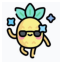

chatbot: @eliza@ 點解有咁既感覺?$覺得$


KeyboardInterrupt: ignored

In [75]:
chatbot(chatbot_params)

In [ ]:
# BertSum, still have some bug
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
import argparse
import logging
import os
from tqdm import tqdm, trange
import json

from preprocess import LCSTSProcessor, convert_examples_to_features, create_dataset
from model import BertAbsSum
from pytorch_pretrained_bert.tokenization import BertTokenizer
from utils import rouge
from utils import convert_to_unicode
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

class InputExample(object):
    """A single training/test example."""

    def __init__(self, guid, src, tgt=None):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            src: string. The untokenized text of the target sequence.
            tgt: (Optional) string. The untokenized text of the target.
        """
        self.guid = guid
        self.src = src
        self.tgt = tgt

BATCH_SIZE = 1

logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)
logger = logging.getLogger(__name__)

parser = argparse.ArgumentParser()
parser.add_argument("--model_path",
                    default=None,
                    type=str,
                    required=True,
                    help="The path to trained model.")
parser.add_argument("--config_path",
                    default=None,
                    type=str,
                    required=True,
                    help="The path to config file.")                    
# parser.add_argument("--eval_path",
#                     default=None,
#                     type=str,
#                     required=True,
#                     help="The path to the evaluation data. Should end with .tsv.")
parser.add_argument("--bert_model", 
                    default=None, 
                    type=str, 
                    required=True,
                    help="Bert pre-trained model selected in the list: bert-base-uncased, "
                    "bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, "
                    "bert-base-multilingual-cased, bert-base-chinese.")
# parser.add_argument("--result_path",
#                     default=None,
#                     type=str,
#                     required=True,
#                     help="The path where you save your results.")                    
parser.add_argument("--max_src_len",
                    default=130,
                    type=int,
                    help="Max sequence length for source text. Sequences will be truncated or padded to this length")
parser.add_argument("--max_tgt_len",
                    default=30,
                    type=int,
                    help="Max sequence length for target text. Sequences will be truncated or padded to this length")


if __name__ == "__main__":
    # args = parser.parse_args()
    args = parser.parse_args(args=['--model_path','/content/drive/MyDrive/chatbot/pretrain-model/output_BTS_re+pr05190/model/BertAbsSum_14.bin',
                                   '--config_path','/content/drive/MyDrive/chatbot/pretrain-model/output_BTS_re+pr05190/model/config.json',
                                   '--bert_model','/content/drive/MyDrive/chatbot/BertSum/pretrained_model/bert-base-chinese'])


    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device=torch.device("cpu")
    with open(args.config_path, 'r') as f:
        config = json.load(f)
    model = BertAbsSum(args.bert_model, config['decoder_config'], device)
    model.load_state_dict(torch.load(args.model_path))
    model.to(device)

    processor = LCSTSProcessor()
    tokenizer = BertTokenizer.from_pretrained(os.path.join(args.bert_model, 'vocab.txt'))
    # test_examples = processor.get_examples(args.eval_path)
    post=input("input:")
    test_examples = [InputExample(guid=0,src=convert_to_unicode(post),tgt=convert_to_unicode(post)),InputExample(guid=1,src=convert_to_unicode(post),tgt=convert_to_unicode(post))]
    test_features = convert_examples_to_features(test_examples, args.max_src_len, args.max_tgt_len, tokenizer)
    test_data = create_dataset(test_features)

    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE, drop_last=True)

    model.eval()
    # if not os.path.exists(args.result_path):
    #     os.mkdir(args.result_path)
    # f_log = open(os.path.join(args.result_path, 'log.txt'), 'w', encoding='utf-8')

    hyp_list = []
    ref_list = []
    for batch in tqdm(test_dataloader, desc="Iteration"):
        batch = tuple(t.to(device) for t in batch)
        pred, beam_score = model.beam_decode(batch[0], batch[1], 3, 3)
        src, tgt = batch[0], batch[2]
        for i in range(BATCH_SIZE):
            sample_src = "".join(tokenizer.convert_ids_to_tokens(src[i].cpu().numpy())).split('[CLS]')[1].split('[SEP]')[0] + '\n'
            sample_tgt = "".join(tokenizer.convert_ids_to_tokens(tgt[i].cpu().numpy())).split('[CLS]')[1].split('[SEP]')[0] + '\n'
            sample_pred = "".join(tokenizer.convert_ids_to_tokens(pred[i][0])).split('[SEP]')[0] + '\n'
            sample_pred_2 = "".join(tokenizer.convert_ids_to_tokens(pred[i][1])).split('[SEP]')[0] + '\n'
            sample_pred_3 = "".join(tokenizer.convert_ids_to_tokens(pred[i][2])).split('[SEP]')[0] + '\n'

            print('Hypothesis: ' + sample_pred)



            print('score: ' + str(beam_score[i]))
            
            # f_hyp.write(sample_pred)
            # f_ref.write(sample_tgt)


        


In [ ]:
!rm -rf /content/CantoneseChatbot